In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import keras as ks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, Callback

# read data

In [2]:
df = pd.read_json (r'./corpora-DO_NOT_SHARE/unified-dataset.json', lines=True)

In [3]:
df['source'].unique()

array(['tec', 'ssec', 'dailydialogues', 'fb-valence-arousal-anon',
       'affectivetext', 'emotiondata-aman', 'electoraltweets',
       'grounded_emotions', 'emotion-cause', 'isear', 'emoint',
       'crowdflower', 'tales-emotion'], dtype=object)

In [4]:
# select only needed sources
df = df.loc[(df['source'] == "tec") | (df['source'] == "crowdflower")]

In [5]:
# remove not needed columns
df = df.drop(columns=['id', 'VAD', 'split', 'domain', 'labeled', 'optional', 'annotation_procedure', 'emotion_model'])

In [6]:
# convert emotions dict to columns
df = df.join(df['emotions'].apply(pd.Series))

In [7]:
# remove not needed columns
df = df.drop(columns=['emotions', 'trust', 'love', 'noemo', 'confusion', 'anticipation', 'shame', 'guilt', 'anticipation'])

In [8]:
# remove not annotated texts
df = df.loc[(df['joy'] != 0) | (df['anger'] != 0) | (df['sadness'] != 0) | (df['disgust'] != 0) | (df['fear'] != 0) | (df['surprise'] != 0)]

# preprocessing

In [9]:
embeddings_index = {}

num_words = 10000
maxlen = df.text.str.split().apply(len).max()
embedding_dim = 100

In [10]:
df.columns

Index(['source', 'text', 'joy', 'anger', 'sadness', 'disgust', 'fear',
       'surprise'],
      dtype='object')

In [11]:
#data_source = df
data_source = df.loc[(df['source'] == "tec")]
#data_source = df.loc[(df['source'] == "crowdflower")]

In [12]:
# select x and y
samples = data_source['text']
labels = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index

padded_sequences = sequence.pad_sequences(sequences, maxlen, padding='post')

In [13]:
f = open("glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [14]:
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [15]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [16]:
padded_sequences[0]

array([1595,   14,   92,    4,  125, 5594,  196,  234,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

# data split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.33, random_state=42)

In [18]:
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights = dict(enumerate(class_weights))

/nix/store/zznsnbalkzq412d5x0skwcgafghv216h-python3-3.8.5-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[5 4 2 ... 5 0 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [19]:
print("Distribution of train-classes: ")
_, idx, count = np.unique(y_train.argmax(axis=1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_train[idx],count)})

Distribution of train-classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 5505, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 1033, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 2625, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 502, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 1871, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 2566}


In [20]:
class_weights

{0: 0.4269452013321223,
 1: 2.275250080671184,
 2: 0.8953650793650794,
 3: 4.681938911022576,
 4: 1.2561909852128987,
 5: 0.9159521953754222}

# model training

In [21]:
# ["conv", "lstm", "simple"]
method = "lstm"

In [22]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))

if method == "conv":
    pass
    model.add(Conv1D(64, (3)))
    model.add(Conv1D(32, (3)))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(Flatten())
if method == "lstm":
    pass
    model.add(Bidirectional(LSTM(32)))

    #model.add(Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    #model.add(Bidirectional(LSTM(32)))#, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
    #model.add(Dropout(0.5))
if method == "simple":
    pass
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(14))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())

model.add(Dense(6, activation='softmax'))

#regularizer backup
# model.add(Dense(6, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Conv1D(32, (3), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(Bidirectional(LSTM(32)))#, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))

#optimizer = Adam(learning_rate=0.0005)
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(x_test,y_test),
                    class_weight=class_weights,
                    callbacks=[
                        ReduceLROnPlateau(monitor='accuracy',
                                          patience=10,
                                          verbose=1,
                                          factor=0.9,
                                          min_lr=0.00001)
                    ])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 1,034,438
Trainable params: 34,438
Non-trainable params: 1,000,000
_________________________________________________________________
None
Epoch 1/100
142/142 [==============================] - 8s 58ms/step - loss: 1.7959 - accuracy: 0.1949 - val_loss: 1.7806 - val_accuracy: 0.1895
Epoch 2/100
142/142 [==============================] - 6s 40ms/step - loss: 1.7686 - accuracy: 0.2180 - val_loss: 1.7516 - val_accuracy: 0.2793
Epoch 3/100
142/142 [==============================] - 6s 41ms/step - loss: 1.

142/142 [==============================] - 6s 39ms/step - loss: 1.3158 - accuracy: 0.4824 - val_loss: 1.3515 - val_accuracy: 0.4762
Epoch 53/100
142/142 [==============================] - 5s 39ms/step - loss: 1.3124 - accuracy: 0.4845 - val_loss: 1.3975 - val_accuracy: 0.4616
Epoch 54/100
142/142 [==============================] - 5s 39ms/step - loss: 1.3083 - accuracy: 0.4863 - val_loss: 1.5884 - val_accuracy: 0.3955
Epoch 55/100
142/142 [==============================] - 5s 37ms/step - loss: 1.3059 - accuracy: 0.4827 - val_loss: 1.4574 - val_accuracy: 0.4477
Epoch 56/100
142/142 [==============================] - 5s 38ms/step - loss: 1.2997 - accuracy: 0.4895 - val_loss: 1.3777 - val_accuracy: 0.4672
Epoch 57/100
142/142 [==============================] - 6s 39ms/step - loss: 1.2982 - accuracy: 0.4891 - val_loss: 1.3446 - val_accuracy: 0.4798
Epoch 58/100
142/142 [==============================] - 6s 39ms/step - loss: 1.2932 - accuracy: 0.4902 - val_loss: 1.5306 - val_accuracy: 0.417

In [23]:
def nn_predict_single(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
    model_output = model.predict(padded_seq)
    return np.argmax(model_output)
def nn_predict_many(texts):
    lst = []
    for row in texts:
        seq = tokenizer.texts_to_sequences([row])
        padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
        lst.append(padded_seq)
    model_output = model.predict(np.vstack(lst))
    return np.argmax(model_output, axis=1)

# history plot

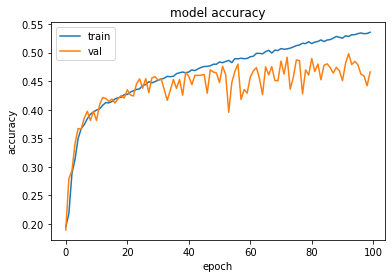

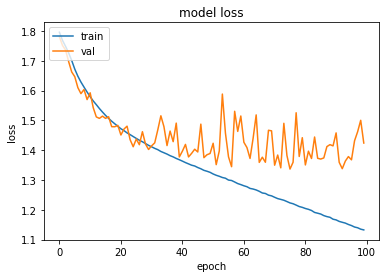

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# scores

In [25]:
from collections import Counter

correct = 0

#data_source = df
#data_source = df.loc[(df['source'] == "tec")]
data_source = df.loc[(df['source'] == "crowdflower")]

val_texts = data_source['text']
y_true = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

print("Distribution of test-classes: ")
_, idx, count = np.unique(y_true.argmax(axis=1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_true[idx],count)})

y_pred = []
# convert one-hot to sequence array
y_true = y_true.argmax(axis=1)

predictions = nn_predict_many(val_texts)
print(predictions)
for i in range(0,len(val_texts)):
    y_pred.append(predictions[i])
    if predictions[i] == y_true[i]:
        correct += 1
y_pred = np.array(y_pred)

Distribution of test-classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 9220, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 1421, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 5123, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 179, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 8430, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 2177}
[1 0 5 ... 0 0 2]


In [26]:
# convert to strings
emotions = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']
y_true = [emotions[x] for x in y_true]
y_pred = [emotions[x] for x in y_pred]

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print("Accuracy:")
print(correct/len(val_texts))
print("F1 score micro")
print(f1_score(y_true, y_pred, average="micro"))
print("F1 score macro")
print(f1_score(y_true, y_pred, average="macro"))

# Look at class wise score
print(classification_report(y_true, y_pred, digits=3))

Accuracy:
0.25322033898305085
F1 score micro
0.25322033898305085
F1 score macro
0.19494780469628928
              precision    recall  f1-score   support

       anger      0.125     0.290     0.174      1421
     disgust      0.009     0.112     0.017       179
        fear      0.380     0.062     0.107      8430
         joy      0.504     0.316     0.388      9220
     sadness      0.259     0.448     0.329      5123
    surprise      0.111     0.257     0.155      2177

    accuracy                          0.253     26550
   macro avg      0.231     0.247     0.195     26550
weighted avg      0.361     0.253     0.254     26550



# confusion matrix

<ipython-input-28-6c14ff1db953>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]+tags)
<ipython-input-28-6c14ff1db953>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""]+tags)


<Figure size 432x288 with 0 Axes>

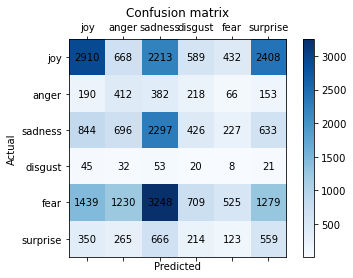

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tags = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']

cm = confusion_matrix(y_true,y_pred, labels = tags)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    im = ax.matshow(cm, cmap=cmap)
    fig.colorbar(im)
    plt.title(title)
    ax.set_xticklabels([""]+tags)
    ax.set_yticklabels([""]+tags)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, z, ha='center', va='center')
    plt.savefig(method + "_conf.png", bbox_inches='tight', transparent=False, pad_inches=0.1,  dpi=500)
    plt.show()

# Compute confusion matrix
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)